# Sea Level

Here, we will applying time-series analysis to the increasing sea levels. The use of the ACF, PACF, and the application of time-series models such as the AR, MA, or ARMA models will be used. 

# Importing Packages

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
import os
import seaborn as sns 
plt.rcParams["figure.figsize"] = (10,6)


# Importing the Dataset

In [3]:
os.chdir('/Users/raph/projects/simulations/datasets/')
sea_lvl = pd.read_csv('./csiro_alt_gmsl_mo_2015.csv')
sea_lvl

,Time,GMSL
0,1993-01-15,-1.6
1,1993-02-15,-3.4
2,1993-03-15,5.5
3,1993-04-15,0.1
4,1993-05-15,5.3
...,...,...
261,2014-10-15,71.7
262,2014-11-15,69.0
263,2014-12-15,76.0
264,2015-01-15,74.5


The dataset contains 266 rows and 2 columns. The first column contains the dates from January 15, 1993 to February 15, 2015. The entries are placed monthly. The second column contains the GMSL (Global Mean Sea Level) at the respective time. Now, we check the data types of the datframe.

In [4]:
sea_lvl.dtypes

Time     object
GMSL    float64
dtype: object

We then change the type of the Time column to the datatime type.

In [5]:
sea_lvl["Time"] = pd.to_datetime(sea_lvl.Time)
sea_lvl.dtypes
sea_lvl.set_index('Time', inplace = True)

# Data Cleaning

We first check whether there are any null values in the dataset.

In [6]:
sea_lvl.isna().value_counts()

GMSL 
False    266
dtype: int64

Since there are no null values, we then chose to normalize the data. To normalize, we subtract the entry by the mean of the dataset followed by dividing the result by the standard deviation.

In [7]:
# sea_lvl['normGMSL'] = (sea_lvl.GMSL -sea_lvl.GMSL.mean())/sea_lvl.GMSL.std()
# sea_lvl.head()

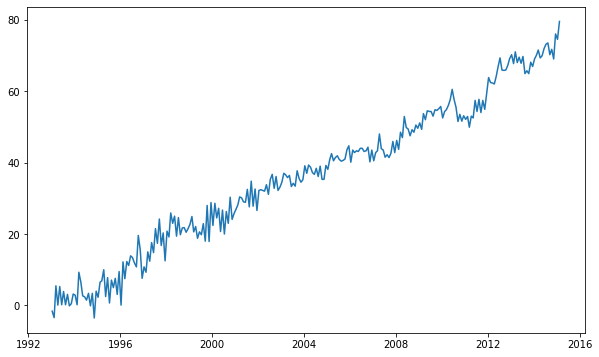

In [8]:
plt.plot(sea_lvl.GMSL)
plt.show()

# Checking Stationarity

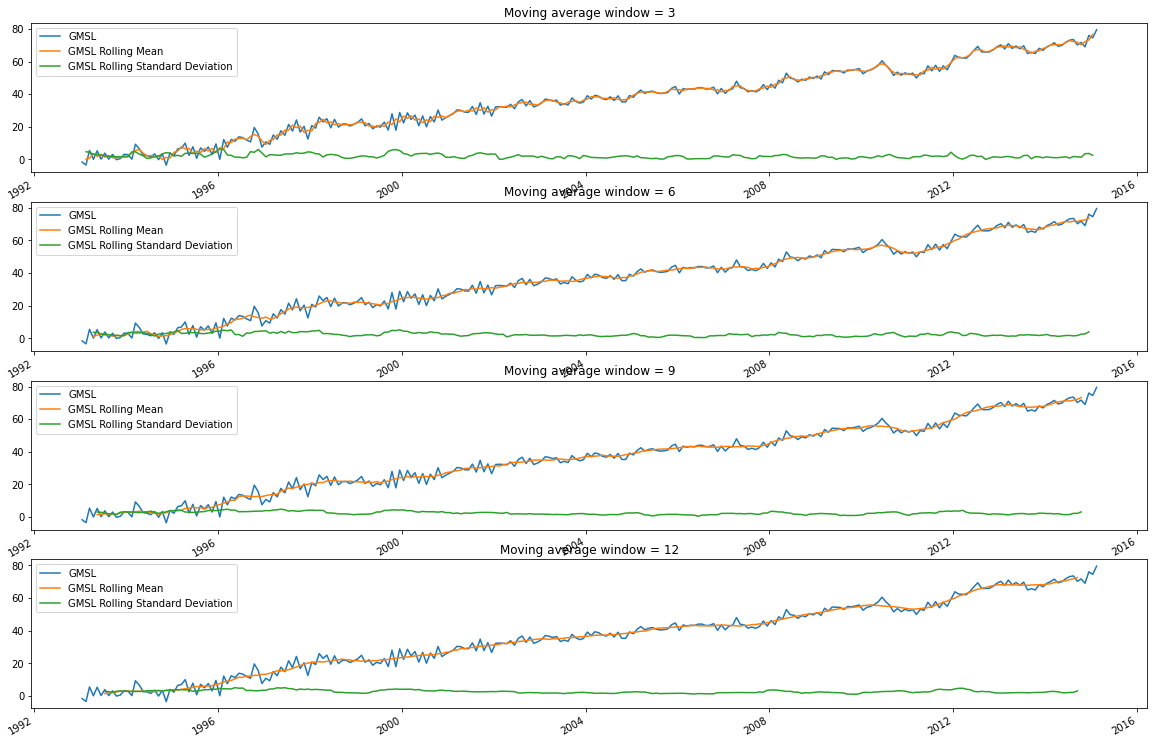

In [10]:
window_sizes = [3, 6, 9, 12]
fig, axes = plt.subplots(len(window_sizes), 1, figsize=(20,14))

for ax_idx, window_size in enumerate(window_sizes):
    sea_lvl.plot(ax=axes[ax_idx], label='GMSL')
    sea_lvl.rolling(window_size, center=True).mean().plot(ax=axes[ax_idx], label='GMSL Rolling Mean')
    sea_lvl.rolling(window_size, center=True).std().plot(ax=axes[ax_idx], label='GMSL Rolling Standard Deviation')

    axes[ax_idx].set_title('Moving average window = {}'.format(window_size))
    axes[ax_idx].set_xlabel('')
    axes[ax_idx].legend(['GMSL','GMSL Rolling Mean',  'GMSL Rolling Standard Deviation'], loc="best")

Looking at the graphs, we would prefer the third and the fourth graph as the they seem to be smoother (closer to a staight line) in comparison to the first two graphs. it also shows that the standar deviation is shown to smoothen as we increase the number of months used in the rolling standard deviation. What is obtained from these visualizations is that the trend for the data is shown to be generally increase while the standard deviation is relatively constant throughout. Now checking the stationarity with the ADF (Augmented Dickey-Fuller Test).

## Augmented Dickey-Fuller Test

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def adf_test(df, test_metric):
    adft = adfuller(df,autolag=test_metric)
    adf_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],\
            "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", \
            "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    return adf_df


In [13]:
adf_test(sea_lvl, 'AIC')

,Values,Metric
0,-0.065279,Test Statistics
1,0.952789,p-value
2,13.000000,No. of lags used
3,252.000000,Number of observations used
4,-3.456569,critical value (1%)
5,-2.873079,critical value (5%)
6,-2.572919,critical value (10%)


As seen from the output, the data is shown to be non-stationary. Thus, we would need to decompose the data to an extent where the data become stationary.

## Decomposition

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

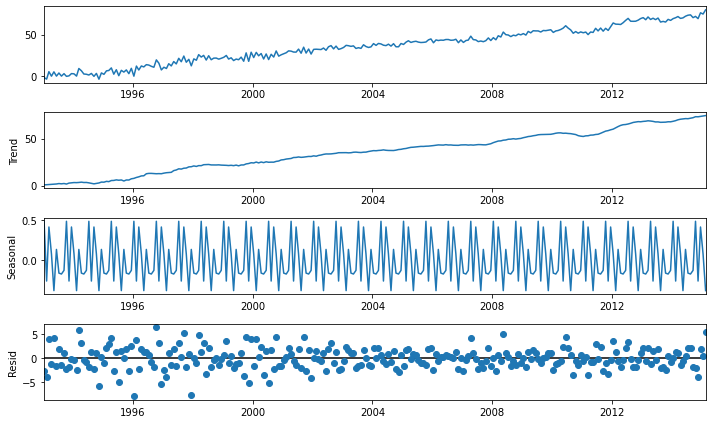

In [15]:
decompose = seasonal_decompose(sea_lvl,model='additive', period=9, extrapolate_trend='freq')

# decompose.trend
decompose.plot()
plt.show()


We can see that under the seasonal data visualization, the data is shown to be more consistent and falling under a fixed interval from -0.5 to 0.5. Now, we test staionarity once more using the ADF test.

In [16]:
sta_sea_lvl = decompose.seasonal
sta_res = decompose.resid
adf_test(decompose.seasonal, 'AIC')

,Values,Metric
0,-3.634786e+15,Test Statistics
1,0.000000e+00,p-value
2,1.400000e+01,No. of lags used
3,2.510000e+02,Number of observations used
4,-3.456674e+00,critical value (1%)
5,-2.873125e+00,critical value (5%)
6,-2.572944e+00,critical value (10%)


Here we see that the seasonal data is shown to be staionary as we reject the null hypothesis. Since the data is already stationary, we can then apply the ACF and the PACF to determine the models. The residuals will be used in checking the ACF and the PACF.

# ACF and PACF

## ACF
The ACF is used to check how well the prevents values are correlated to the past values. To know the how big the intervals into the past we need to go. We use the rule of thumb to take the ceiling($\ln$(number of entries). )

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [18]:
lag = np.ceil(np.log(len(sea_lvl)))
print('Number of Lags: {}'.format(lag))

Number of Lags: 6.0


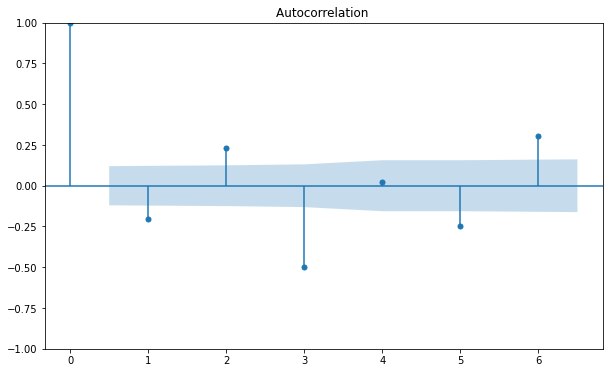

In [19]:
plot_acf(sta_res, lags =6, alpha = 0.05, title = 'Autocorrelation ', zero = True)
plt.show()

We can see from the ACF visualization that the values tend to 0 or stay close or within the Barlett band. This would imply that there would be no correlation between the past and present values. Extending this would show that at we increased the lagged values then serial correlation does end up disappearing. Here the first significant drop can be seen in the first lag. Applying the same technique on the PACF this should show a more refined check on whether the data exhibits serial correlation.

/Users/raph/virtualenvs/venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


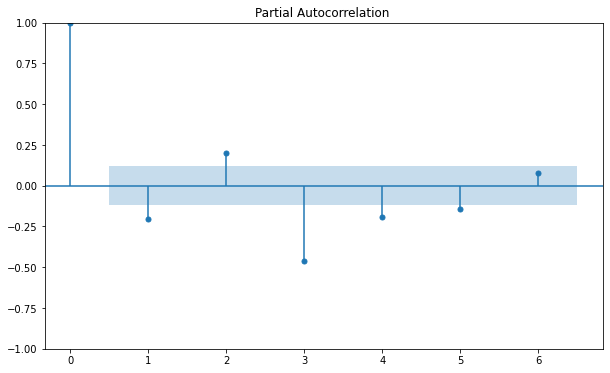

In [20]:
plot_pacf(sta_res, lags =6, alpha = 0.05, title = 'Partial Autocorrelation ', zero = True)
plt.show()

Once again, the most significant drop would be in the first lag as seen in the PACF. We then apply the auto_arima function to see what models are the most suitable to use for this dataset.

# Auto ARIMA

## Creating a Testing and Training Dataset

In [21]:
tr_len = int(np.ceil(len(sea_lvl)*0.8))
te_len = len(sea_lvl) - tr_len

train = sea_lvl.iloc[:tr_len,0]
test = sea_lvl.iloc[tr_len:,0]

Here the train dataset has 213 entries while the test dataset has 53 entries. Now applying the auto arima function

In [22]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, m=12, D=1, seasonal=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1106.190, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1105.400, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1215.469, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1108.183, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1064.806, Time=0.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1064.475, Time=0.36 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1103.402, Time=0.17 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1065.691, Time=0.45 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1040.9

We then chose the ARIMA(3,0,1) with a seasonality order of (2,1,2) model.

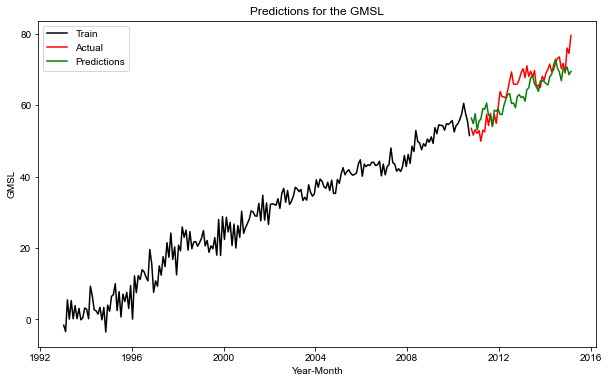

In [23]:
plt.plot(train, color = "black", label ='Train')
plt.plot(test, color = "red", label = 'Actual')
plt.plot(forecast, color='green', label = 'Predictions')
plt.legend()
plt.title("Predictions for the GMSL")
plt.ylabel("GMSL")
plt.xlabel('Year-Month')
sns.set()
plt.show()

Now, we test the residuals obtained from the model to see whether the residuals of the model used have any autocorrealtion. This is to show whether the model used is suffieicnt enough as the results of having autocrrelation would mean that the model is insuffienct and may still lack key variables to capture the data.

# Residual Analysis

## Suffiency of the Model

In [27]:
res = model.resid()

To check for autocorrelation, we apply the Ljung-Box test.

In [28]:
sm.stats.acorr_ljungbox(res, lags = [6])

,lb_stat,lb_pvalue
6,3.148255,0.790022


Since we do not reject the null hypothesis, then the model is sufficient. Other tests can also be applied to show the properties of the residuals.

## Normality

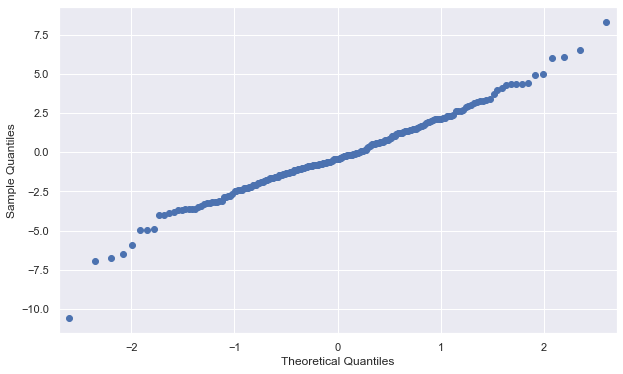

In [31]:
qqplot(res)
plt.show()

In [29]:
import scipy.stats as stats
stats.shapiro(res)

ShapiroResult(statistic=0.9857416749000549, pvalue=0.030818866565823555)

Here, we can see that the data is normally distributed at the 1% LoS. However, at the 5% LoS we see that it is not significant. Despite the QQplot showing a relative linear line. This may come from the fact that there are outliers as seen on the ends of the visualization.